<a href="https://colab.research.google.com/github/dansarmiento/ColaboratoryNotebooks/blob/main/MIPS_National_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project will create a database and perform analysis on the public MIPS data


In [1]:
# Import libraries to make a database file out of related CMS datasets
# pandas for dataframes, requests for importing data from API
# sqlite3 for creating the database file
import pandas as pd
import requests
import sqlite3

# import visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
#create the database file cms_quality
mips_analysis = sqlite3.connect('mips_analysis')

In [3]:
# download the dataset from the link
# https://data.cms.gov/search?keywords=Quality%20Payment%20Program%20Experience&sort=Relevancy
# import the cms quality payment program dataset
df = pd.read_csv('2022_puf.csv', low_memory=False)
# clean up the columns
df.columns = df.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','')
df.head()

,provider_key,practice_state_or_us_territory,practice_size,clinician_type,clinician_specialty,years_in_medicare,npi,non_reporting,participation_option,medicare_patients,allowed_charges,services,opted_into_mips,small_practice_status,rural_status,health_professional_shortage_area_status,ambulatory_surgical_center_based_status,hospital_based_status,non_patient_facing_status,facility_based_status,dual_eligibility_ratio,safety_net_status,extreme_uncontrollable_circumstance_euc,final_score,payment_adjustment_percentage,complex_patient_bonus,quality_reweighting_euc,quality_category_score,quality_improvement_score,small_practice_bonus,quality_measure_id_1,quality_measure_collection_type_1,quality_measure_score_1,quality_measure_id_2,quality_measure_collection_type_2,quality_measure_score_2,quality_measure_id_3,quality_measure_collection_type_3,quality_measure_score_3,quality_measure_id_4,quality_measure_collection_type_4,quality_measure_score_4,quality_measure_id_5,quality_measure_collection_type_5,quality_measure_score_5,quality_measure_id_6,quality_measure_collection_type_6,quality_measure_score_6,quality_measure_id_7,quality_measure_collection_type_7,quality_measure_score_7,quality_measure_id_8,quality_measure_collection_type_8,quality_measure_score_8,quality_measure_id_9,quality_measure_collection_type_9,quality_measure_score_9,quality_measure_id_10,quality_measure_collection_type_10,quality_measure_score_10,quality_measure_id_11,quality_measure_collection_type_11,quality_measure_score_11,quality_measure_id_12,quality_measure_collection_type_12,quality_measure_score_12,promoting_interoperability_pi_category_score,pi_reweighting_euc,pi_reweighting_hardship_exception,pi_reweighting_special_status_or_clinician_type,cehrt_id,pi_measure_id_1,pi_measure_type_1,pi_measure_score_1,pi_measure_id_2,pi_measure_type_2,pi_measure_score_2,pi_measure_id_3,pi_measure_type_3,pi_measure_score_3,pi_measure_id_4,pi_measure_type_4,pi_measure_score_4,pi_measure_id_5,pi_measure_type_5,pi_measure_score_5,pi_measure_id_6,pi_measure_type_6,pi_measure_score_6,pi_measure_id_7,pi_measure_type_7,pi_measure_score_7,pi_measure_id_8,pi_measure_type_8,pi_measure_score_8,pi_measure_id_9,pi_measure_type_9,pi_measure_score_9,pi_measure_id_10,pi_measure_type_10,pi_measure_score_10,pi_measure_id_11,pi_measure_type_11,pi_measure_score_11,improvement_activities_ia_category_score,ia_reweighting_euc,ia_credit,ia_measure_id_1,ia_measure_score_1,ia_measure_id_2,ia_measure_score_2,ia_measure_id_3,ia_measure_score_3,ia_measure_id_4,ia_measure_score_4,cost_category_score,cost_reweighting_euc,cost_measure_id_1,cost_measure_achievement_points_1,cost_measure_id_2,cost_measure_achievement_points_2,cost_measure_id_3,cost_measure_achievement_points_3,cost_measure_id_4,cost_measure_achievement_points_4,cost_measure_id_5,cost_measure_achievement_points_5,cost_measure_id_6,cost_measure_achievement_points_6,cost_measure_id_7,cost_measure_achievement_points_7,cost_measure_id_8,cost_measure_achievement_points_8,cost_measure_id_9,cost_measure_achievement_points_9,cost_measure_id_10,cost_measure_achievement_points_10,cost_measure_id_11,cost_measure_achievement_points_11,cost_measure_id_12,cost_measure_achievement_points_12,cost_measure_id_13,cost_measure_achievement_points_13,cost_measure_id_14,cost_measure_achievement_points_14,cost_measure_id_15,cost_measure_achievement_points_15,cost_measure_id_16,cost_measure_achievement_points_16,cost_measure_id_17,cost_measure_achievement_points_17,cost_measure_id_18,cost_measure_achievement_points_18,cost_measure_id_19,cost_measure_achievement_points_19,cost_measure_id_20,cost_measure_achievement_points_20,cost_measure_id_21,cost_measure_achievement_points_21,cost_measure_id_22,cost_measure_achievement_points_22,cost_measure_id_23,cost_measure_achievement_points_23,cost_measure_id_24,cost_measure_achievement_points_24
0,621,TX,4,Physical Therapist,Physical Therapist in Private Practice,13,1942539911,False,Virtual Group,626,815900.57,18708,False,False,

In [4]:
# create a unique identifier from npi and provider key because many npi are repeated through the dataset
df['npi_unique'] = df.npi.astype(str) + '_' + df.provider_key.astype(str)

In [5]:
# separate the organization dimensions and add a composite column as a unique identifier
dim_organization = df[['provider_key','practice_state_or_us_territory','practice_size','clinician_type','clinician_specialty',
                    'years_in_medicare','npi','non_reporting','participation_option','medicare_patients','allowed_charges',
                    'services','opted_into_mips','small_practice_status','rural_status','health_professional_shortage_area_status',
                    'ambulatory_surgical_center_based_status','hospital_based_status','non_patient_facing_status',
                    'facility_based_status','dual_eligibility_ratio','safety_net_status','extreme_uncontrollable_circumstance_euc',
                    'final_score','payment_adjustment_percentage','complex_patient_bonus','small_practice_bonus']]
dim_organization['npi_unique'] = dim_organization.npi.astype(str) + '_' + dim_organization.provider_key.astype(str)
dim_organization.to_sql('dim_organization', mips_analysis, if_exists='replace', index=False)

<ipython-input-5-4d130a5d19c3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dim_organization['npi_unique'] = dim_organization.npi.astype(str) + '_' + dim_organization.provider_key.astype(str)


40387

# Seaborn visualization for value distributions

In [13]:
# look at the value distribution with seaborn
# try different graphs from https://python-graph-gallery.com/
# Get numerical and categorical columns
numerical = dim_organization.select_dtypes(include=['number']).columns.tolist()
categorical = dim_organization.select_dtypes(include=['object','boolean']).columns.tolist()

# clean up the lists
items_to_remove = ['provider_key', 'npi', 'npi_unique']

# Remove items using list comprehension
numerical = [item for item in numerical if item not in items_to_remove]
categorical = [item for item in categorical if item not in items_to_remove]


In [9]:
# focus provider types =
# ['Physician Assistant', 'Doctor of Medicine', 'Nurse Practitioner', 'Doctor of Osteopathy']
clinician_types = dim_organization.clinician_type.unique().tolist()
clinician_filter = ['Physician Assistant', 'Doctor of Medicine', 'Nurse Practitioner', 'Doctor of Osteopathy']
clinician_df = dim_organization[dim_organization.clinician_type.isin(clinician_filter)]
clinician_df.head()

,provider_key,practice_state_or_us_territory,practice_size,clinician_type,clinician_specialty,years_in_medicare,npi,non_reporting,participation_option,medicare_patients,allowed_charges,services,opted_into_mips,small_practice_status,rural_status,health_professional_shortage_area_status,ambulatory_surgical_center_based_status,hospital_based_status,non_patient_facing_status,facility_based_status,dual_eligibility_ratio,safety_net_status,extreme_uncontrollable_circumstance_euc,final_score,payment_adjustment_percentage,complex_patient_bonus,small_practice_bonus,npi_unique
7,70978,MI,3,Physician Assistant,Physician Assistant,16,1942376348,False,Virtual Group,2684,1625893.00,11595,False,False,False,False,False,False,False,False,0.16,False,False,76.79,0.16,10.0,0.0,1942376348_70978
11,96099,MI,4,Physician Assistant,Physician Assistant,18,1134138480,False,Virtual Group,2684,1625893.00,11595,False,False,False,False,False,False,False,False,0.16,False,False,76.79,0.16,10.0,0.0,1134138480_96099
29,277237,CA,2,Doctor of Medicine,Internal Medicine,18,1558324913,False,Virtual Group,1181,6792130.59,6981,False,True,False,False,False,False,False,False,0.62,True,False,67.21,-0.93,10.0,6.0,1558324913_277237
33,293761,MI,5,Physician Assistant,Physician Assistant,16,1093763088,False,Virtual Group,2684,1625893.00,11595,False,False,False,False,False,False,False,False,0.16,False,False,76.79,0.16,10.0,0.0,1093763088_293761
35,305154,MI,3,Physician Assistant,Physician Assistant,12,1548542178,False,Virtual Group,2684,1625893.00,11595,False,False,False,False,False,False,False,False,0.16,False,False,76.79,0.16,10.0,0.0,1548542178_305154


In [14]:
state_subset = ['CA','FL','TX','NY']
clinician_df = clinician_df[clinician_df.practice_state_or_us_territory.isin(state_subset)]
categorical

['practice_state_or_us_territory',
 'clinician_type',
 'clinician_specialty',
 'non_reporting',
 'participation_option',
 'opted_into_mips',
 'small_practice_status',
 'rural_status',
 'health_professional_shortage_area_status',
 'ambulatory_surgical_center_based_status',
 'hospital_based_status',
 'non_patient_facing_status',
 'facility_based_status',
 'safety_net_status',
 'extreme_uncontrollable_circumstance_euc']

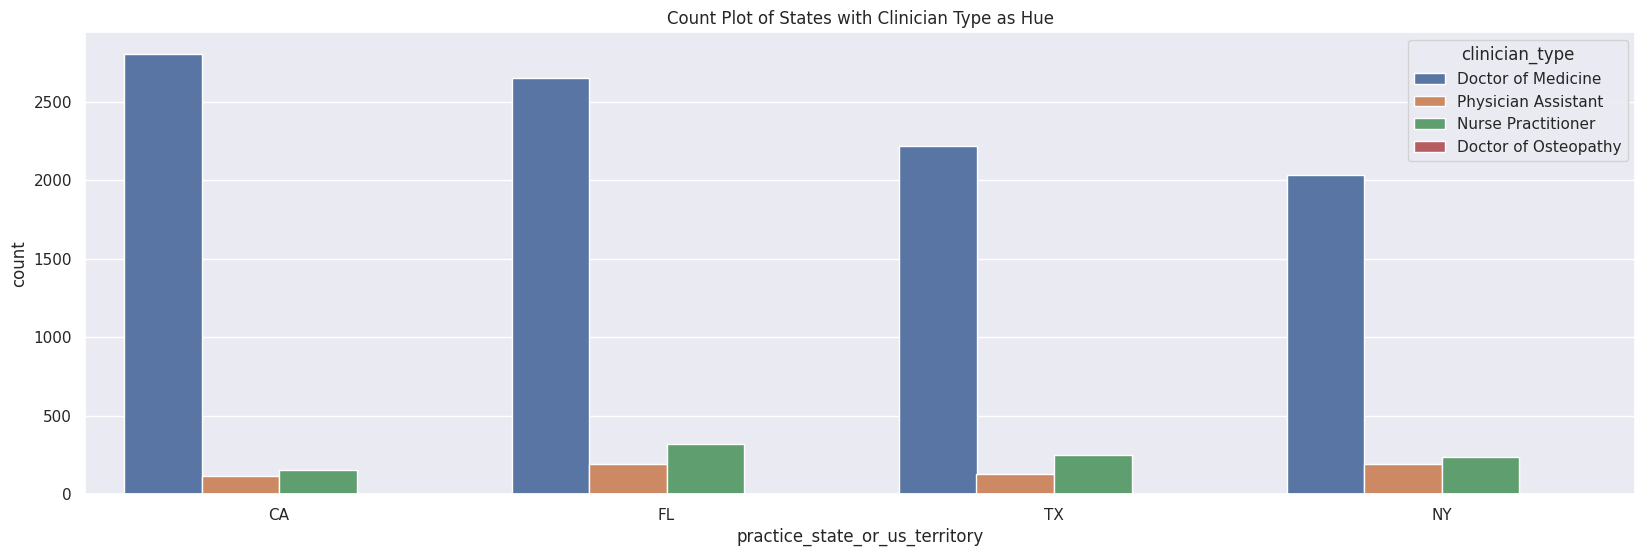

In [11]:
# four similar states are CA, FL, TX, and NY
# Set the figure size
sns.set(rc={'figure.figsize':(20, 6)})  # width, height in inches
# Count Plot with Hue
sns.countplot(x='practice_state_or_us_territory', hue='clinician_type', data=clinician_df)
plt.title('Count Plot of States with Clinician Type as Hue')
plt.show()

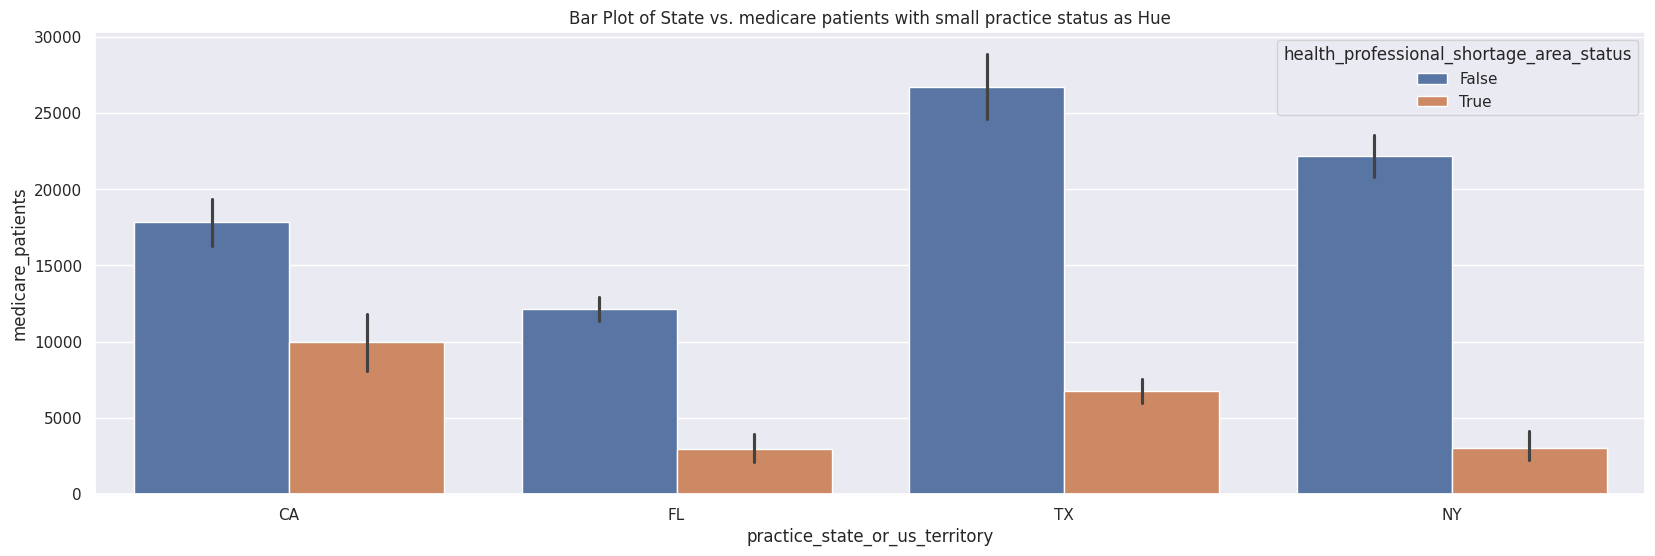

In [16]:
# Bar Plot with Hue
sns.barplot(x='practice_state_or_us_territory', y='medicare_patients', hue='health_professional_shortage_area_status', data=clinician_df)
plt.title('Bar Plot of State vs. medicare patients with small practice status as Hue')
plt.show()

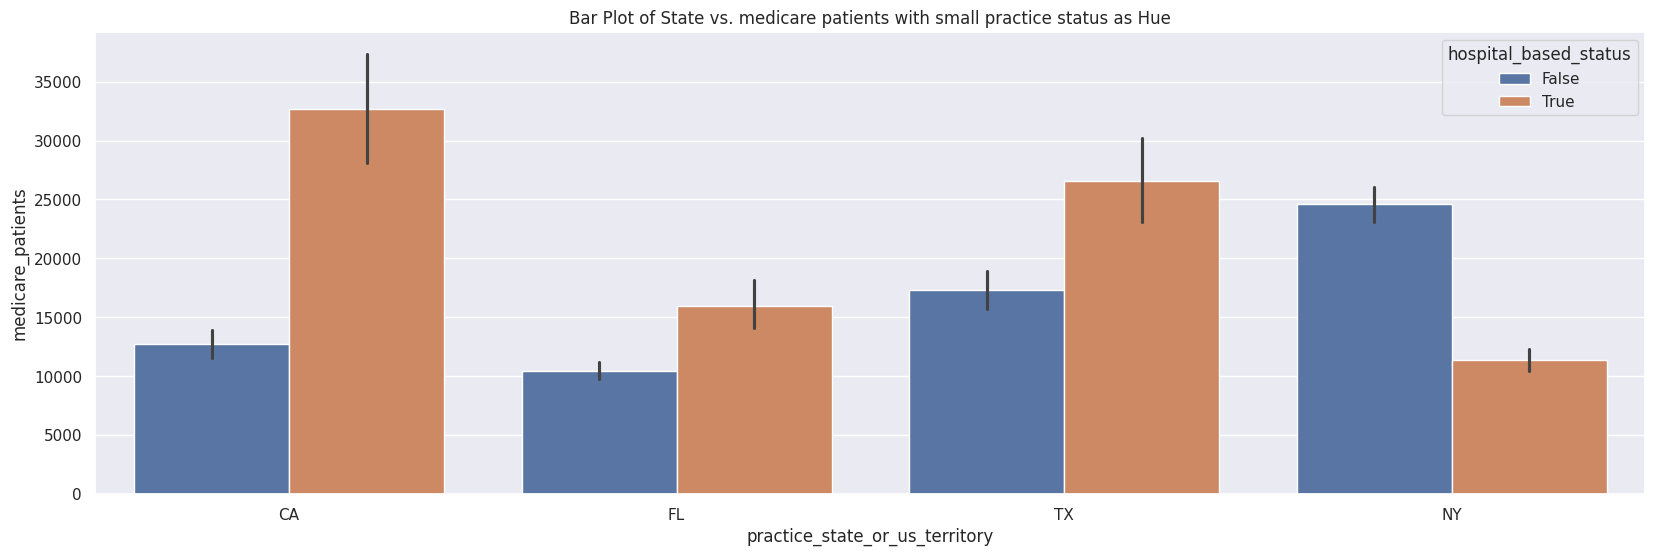

In [18]:
'''
 'ambulatory_surgical_center_based_status',
 'hospital_based_status',
 'non_patient_facing_status',
 'facility_based_status',
 'safety_net_status',
 'extreme_uncontrollable_circumstance_euc'
 '''
# Bar Plot with Hue
sns.barplot(x='practice_state_or_us_territory', y='medicare_patients', hue='hospital_based_status', data=clinician_df)
plt.title('Bar Plot of State vs. medicare patients with small practice status as Hue')
plt.show()

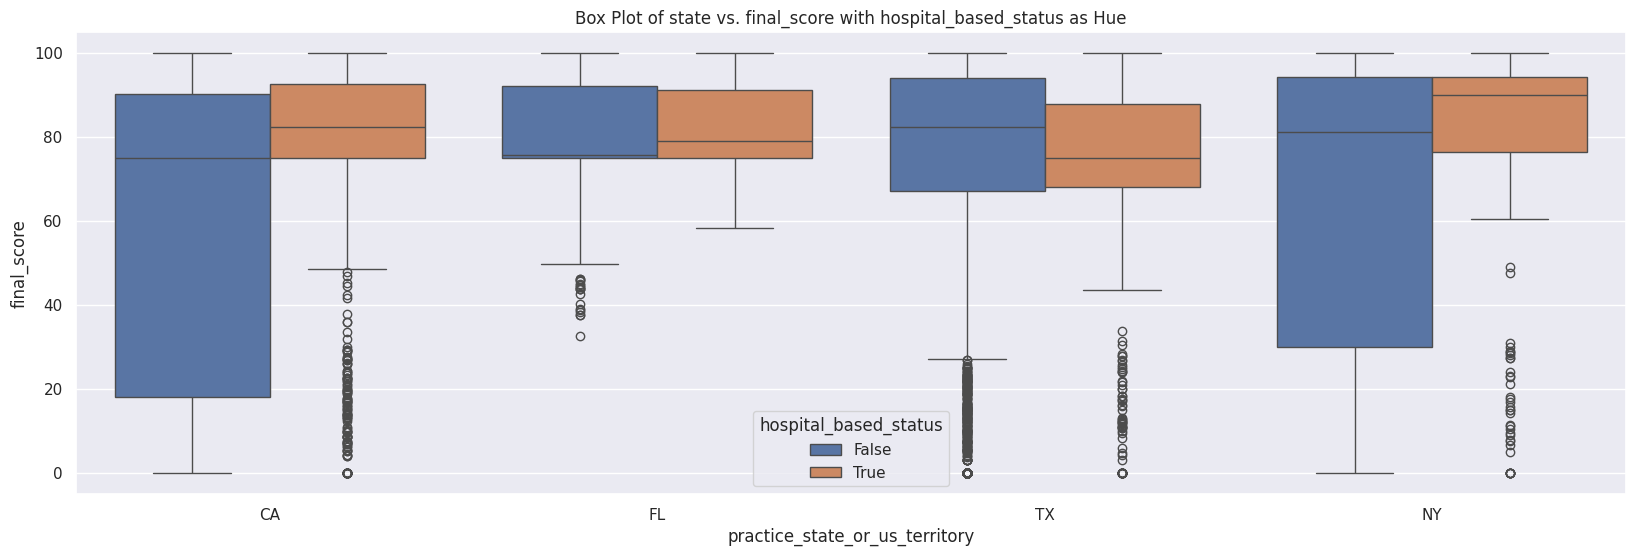

In [19]:
# surprising score distribution for hospital based in CA, TX, and NY.  Only TX and FL have low outliers for non-hospital based
sns.boxplot(x='practice_state_or_us_territory', y='final_score', hue='hospital_based_status', data=clinician_df)
plt.title('Box Plot of state vs. final_score with hospital_based_status as Hue')
plt.show()

In [ ]:
sns.violinplot(x='Category1', y='Value', hue='Category2', data=df, split=True)
plt.title('Violin Plot of Category1 vs. Value with Category2 as Hue')
plt.show()

In [ ]:
# Create a pivot table
pivot_table = df.pivot_table(index='Category1', columns='Category2', values='Value', aggfunc='mean')

# Heatmap
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Heatmap of Average Value by Category1 and Category2')
plt.show()

In [ ]:
# Clustered Bar Plot
sns.catplot(x='Category1', hue='Category2', kind='bar', data=df, height=4, aspect=2)
plt.title('Clustered Bar Plot of Category1 and Category2')
plt.show()

In [ ]:
# Create a crosstab
crosstab = pd.crosstab(df['Category1'], df['Category2'])

# Stacked Bar Plot
crosstab.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot of Category1 and Category2')
plt.xlabel('Category1')
plt.ylabel('Count')
plt.show()

# Segregating each category and creating a table for it

In [ ]:
# make a list of each major category and a dictionary to relabel the variables for clarity
categories = ['quality','pi','ia','cost']
category_mapping = {'quality': 'quality', 'pi': 'interoperability', 'ia': 'improvement', 'cost': 'cost'}

# Create and assign lists dynamically
for category in categories:
    context = [col for col in df.columns if category in col or 'npi' in col or 'npi_unique' in col]
    category_name = category_mapping[category]
    globals()[category_name] = context

# Display the results
for category in categories:
    category_name = category_mapping[category]

In [ ]:
# check the results and clean
# quality looks good
print(quality)
# need to remove 'hospital_based_status' from interoperability
print(interoperability)
# need to remove 'clinician_type', 'clinician_specialty', 'pi_reweighting_special_status_or_clinician_type' from improvement
print(improvement)
# cost looks good
print(cost)

In [ ]:
# List of items to remove
items_to_remove = ['hospital_based_status', 'clinician_type', 'clinician_specialty', 'pi_reweighting_special_status_or_clinician_type']

# Remove items using list comprehension
interoperability = [item for item in interoperability if item not in items_to_remove]
improvement = [item for item in improvement if item not in items_to_remove]

In [ ]:
# make the category context tables for each category
context_table_list = [quality,interoperability,improvement,cost]
category_names = ['quality', 'interoperability', 'improvement', 'cost']

# Iterate through the list to create tables from the filtered columns lists
for table, name in zip(context_table_list, category_names):
    # Dynamically create the dataframe variable
    globals()['src_' + name] = df[table]

In [ ]:
# create tables from all the dataframes
table_creation_list = [src_quality,src_interoperability,src_improvement,src_cost]
# Create a dictionary with table names and corresponding dataframes
table_creation_dict = {
    'src_quality': src_quality,
    'src_interoperability': src_interoperability,
    'src_improvement': src_improvement,
    'src_cost': src_cost
}

# Iterate through the dictionary to create tables from the dataframes
for table_name, dataframe in table_creation_dict.items():
    dataframe.to_sql(table_name, mips_analysis, if_exists='replace', index=False)

# Importing measure definitions and creating tables for them

In [ ]:
# data source https://qpp.cms.gov/mips/explore-measures?tab=qualityMeasures&py=2024
# explore the measures and activities
# import each of the measure dimension tables
# quality
quality = pd.read_csv('2024-qualityMeasures.csv')
quality.columns = quality.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','').str.lower()
quality.to_sql('dim_quality', mips_analysis, if_exists='replace', index=False)

# improvement
improvement = pd.read_csv('2024-improvementActivities.csv')
improvement.columns = improvement.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','').str.lower()
improvement.to_sql('dim_improvement', mips_analysis, if_exists='replace', index=False)

#interop
interoperability = pd.read_csv('2024-promotingInteroperability.csv')
interoperability.columns = interoperability.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','').str.lower()
interoperability.to_sql('dim_interoperability', mips_analysis, if_exists='replace', index=False)

#cost
cost = pd.read_csv('2024-costMeasures.csv')
cost.columns = cost.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','').str.lower()
cost.to_sql('dim_cost', mips_analysis, if_exists='replace', index=False)

29

In [ ]:
# create the flat tables individually - quality
quality_flat = src_quality[['npi_unique', 'quality_measure_id_1', 'quality_measure_score_1', 'quality_measure_id_2',
                      'quality_measure_score_2', 'quality_measure_id_3', 'quality_measure_score_3',
                      'quality_measure_id_4', 'quality_measure_score_4', 'quality_measure_id_5',
                      'quality_measure_score_5', 'quality_measure_id_6', 'quality_measure_score_6',
                      'quality_measure_id_7', 'quality_measure_score_7', 'quality_measure_id_8',
                      'quality_measure_score_8', 'quality_measure_id_9', 'quality_measure_score_9',
                      'quality_measure_id_10', 'quality_measure_score_10', 'quality_measure_id_11',
                      'quality_measure_score_11', 'quality_measure_id_12', 'quality_measure_score_12']]
# Melt the dataframe for IDs
id_vars = ['npi_unique']
value_vars = [col for col in quality_flat.columns if 'quality_measure_id' in col or 'quality_measure_score' in col]

# Separate IDs and Scores
melted_id = pd.melt(quality_flat, id_vars=id_vars, value_vars=[col for col in quality_flat.columns if 'quality_measure_id' in col], var_name='measure', value_name='quality_measure_id')
melted_score = pd.melt(quality_flat, id_vars=id_vars, value_vars=[col for col in quality_flat.columns if 'quality_measure_score' in col], var_name='measure', value_name='quality_measure_score')

# Ensure 'measure' values are the same to merge on
melted_id['measure'] = melted_id['measure'].str.extract('(\d+)').astype(int)
melted_score['measure'] = melted_score['measure'].str.extract('(\d+)').astype(int)

# Merge melted dataframes on 'npi' and 'measure'
merged_df = pd.merge(melted_id, melted_score, on=['npi_unique', 'measure'])

# Drop rows where both quality_measure_id and quality_measure_score are null
merged_df = merged_df.dropna(subset=['quality_measure_id', 'quality_measure_score'], how='all')

# Add the npi back in
merged_df['npi'] = merged_df['npi_unique'].str.split('_').str[0]

# write to database
merged_df.to_sql('stg_quality_flat',mips_analysis, if_exists='replace', index=False)

436220

In [ ]:
interoperability_flat = src_interoperability[['npi_unique',  'pi_measure_id_1',  'pi_measure_score_1',
       'pi_measure_id_2',  'pi_measure_score_2', 'pi_measure_id_3',  'pi_measure_score_3',
       'pi_measure_id_4',  'pi_measure_score_4', 'pi_measure_id_5',  'pi_measure_score_5',
       'pi_measure_id_6',  'pi_measure_score_6', 'pi_measure_id_7',  'pi_measure_score_7',
       'pi_measure_id_8',  'pi_measure_score_8', 'pi_measure_id_9',  'pi_measure_score_9',
       'pi_measure_id_10',  'pi_measure_score_10', 'pi_measure_id_11',  'pi_measure_score_11']]

# Melt the dataframe for IDs
id_vars = ['npi_unique']
value_vars = [col for col in interoperability_flat.columns if 'pi_measure_id' in col or 'pi_measure_score' in col]

# Separate IDs and Scores
melted_id = pd.melt(interoperability_flat, id_vars=id_vars, value_vars=[col for col in interoperability_flat.columns if 'pi_measure_id' in col], var_name='measure', value_name='pi_measure_id')
melted_score = pd.melt(interoperability_flat, id_vars=id_vars, value_vars=[col for col in interoperability_flat.columns if 'pi_measure_score' in col], var_name='measure', value_name='pi_measure_score')

# Ensure 'measure' values are the same to merge on
melted_id['measure'] = melted_id['measure'].str.extract('(\d+)').astype(int)
melted_score['measure'] = melted_score['measure'].str.extract('(\d+)').astype(int)

# Merge melted dataframes on 'npi' and 'measure'
merged_df = pd.merge(melted_id, melted_score, on=['npi_unique', 'measure'])

# Drop rows where both quality_measure_id and quality_measure_score are null
merged_df = merged_df.dropna(subset=['pi_measure_id', 'pi_measure_score'], how='all')

# Add the npi back in
merged_df['npi'] = merged_df['npi_unique'].str.split('_').str[0]

# write to database
merged_df.to_sql('stg_interoperability_flat',mips_analysis, if_exists='replace', index=False)

131189

In [ ]:
improvement_flat = src_improvement[['npi_unique','ia_measure_id_1', 'ia_measure_score_1', 'ia_measure_id_2',
       'ia_measure_score_2', 'ia_measure_id_3', 'ia_measure_score_3',
       'ia_measure_id_4', 'ia_measure_score_4']]

# Melt the dataframe for IDs
id_vars = ['npi_unique']
value_vars = [col for col in improvement_flat.columns if 'ia_measure_id' in col or 'ia_measure_score' in col]

# Separate IDs and Scores
melted_id = pd.melt(improvement_flat, id_vars=id_vars, value_vars=[col for col in improvement_flat.columns if 'ia_measure_id' in col], var_name='measure', value_name='ia_measure_id')
melted_score = pd.melt(improvement_flat, id_vars=id_vars, value_vars=[col for col in improvement_flat.columns if 'ia_measure_score' in col], var_name='measure', value_name='ia_measure_score')

# Ensure 'measure' values are the same to merge on
melted_id['measure'] = melted_id['measure'].str.extract('(\d+)').astype(int)
melted_score['measure'] = melted_score['measure'].str.extract('(\d+)').astype(int)

# Merge melted dataframes on 'npi' and 'measure'
merged_df = pd.merge(melted_id, melted_score, on=['npi_unique', 'measure'])

# Drop rows where both quality_measure_id and quality_measure_score are null
merged_df = merged_df.dropna(subset=['ia_measure_id', 'ia_measure_score'], how='all')

# Add the npi back in
merged_df['npi'] = merged_df['npi_unique'].str.split('_').str[0]

# write to database
merged_df.to_sql('stg_improvement_flat',mips_analysis, if_exists='replace', index=False)

90875

# Unpivoting each category table and writing this to a table

In [ ]:
cost_flat = src_cost[['npi_unique', 'cost_measure_id_1', 'cost_measure_achievement_points_1', 'cost_measure_id_2', 'cost_measure_achievement_points_2', 'cost_measure_id_3',
       'cost_measure_achievement_points_3', 'cost_measure_id_4', 'cost_measure_achievement_points_4', 'cost_measure_id_5',
       'cost_measure_achievement_points_5', 'cost_measure_id_6', 'cost_measure_achievement_points_6', 'cost_measure_id_7',
       'cost_measure_achievement_points_7', 'cost_measure_id_8', 'cost_measure_achievement_points_8', 'cost_measure_id_9',
       'cost_measure_achievement_points_9', 'cost_measure_id_10', 'cost_measure_achievement_points_10', 'cost_measure_id_11',
       'cost_measure_achievement_points_11', 'cost_measure_id_12', 'cost_measure_achievement_points_12', 'cost_measure_id_13',
       'cost_measure_achievement_points_13', 'cost_measure_id_14', 'cost_measure_achievement_points_14', 'cost_measure_id_15',
       'cost_measure_achievement_points_15', 'cost_measure_id_16', 'cost_measure_achievement_points_16', 'cost_measure_id_17',
       'cost_measure_achievement_points_17', 'cost_measure_id_18', 'cost_measure_achievement_points_18', 'cost_measure_id_19',
       'cost_measure_achievement_points_19', 'cost_measure_id_20', 'cost_measure_achievement_points_20', 'cost_measure_id_21',
       'cost_measure_achievement_points_21', 'cost_measure_id_22', 'cost_measure_achievement_points_22', 'cost_measure_id_23',
       'cost_measure_achievement_points_23', 'cost_measure_id_24', 'cost_measure_achievement_points_24']]

# Melt the dataframe for IDs
id_vars = ['npi_unique']
value_vars = [col for col in cost_flat.columns if 'cost_measure_id' in col or 'cost_measure_achievement_points' in col]

# Separate IDs and Scores
melted_id = pd.melt(cost_flat, id_vars=id_vars, value_vars=[col for col in cost_flat.columns if 'cost_measure_id' in col], var_name='measure', value_name='cost_measure_id')
melted_score = pd.melt(cost_flat, id_vars=id_vars, value_vars=[col for col in cost_flat.columns if 'cost_measure_achievement_points' in col], var_name='measure', value_name='cost_measure_achievement_points')

# Ensure 'measure' values are the same to merge on
melted_id['measure'] = melted_id['measure'].str.extract('(\d+)').astype(int)
melted_score['measure'] = melted_score['measure'].str.extract('(\d+)').astype(int)

# Merge melted dataframes on 'npi' and 'measure'
merged_df = pd.merge(melted_id, melted_score, on=['npi_unique', 'measure'])

# Drop rows where both quality_measure_id and quality_measure_score are null
merged_df = merged_df.dropna(subset=['cost_measure_id', 'cost_measure_achievement_points'], how='all')

# Add the npi back in
merged_df['npi'] = merged_df['npi_unique'].str.split('_').str[0]

# write to database
merged_df.to_sql('stg_cost_flat',mips_analysis, if_exists='replace', index=False)

212322

In [ ]:
# lets look at the database
pd.read_sql_query('select * from sqlite_master where type = "table"', mips_analysis)

,type,name,tbl_name,rootpage,sql
0,table,dim_organization,dim_organization,2,"CREATE TABLE ""dim_organization"" (\n""provider_k..."
1,table,src_quality,src_quality,2451,"CREATE TABLE ""src_quality"" (\n""npi"" INTEGER,\n..."
2,table,src_interoperability,src_interoperability,6679,"CREATE TABLE ""src_interoperability"" (\n""npi"" I..."
3,table,src_improvement,src_improvement,8428,"CREATE TABLE ""src_improvement"" (\n""npi"" INTEGE..."
4,table,src_cost,src_cost,9342,"CREATE TABLE ""src_cost"" (\n""npi"" INTEGER,\n ""..."
5,table,dim_quality,dim_quality,11683,"CREATE TABLE ""dim_quality"" (\n""measure_name"" T..."
6,table,dim_improvement,dim_improvement,11713,"CREATE TABLE ""dim_improvement"" (\n""activity_na..."
7,table,dim_interoperability,dim_interoperability,11736,"CREATE TABLE ""dim_interoperability"" (\n""measur..."
8,table,dim_cost,dim_cost,11742,"CREATE TABLE ""dim_cost"" (\n""measure_name"" TEXT..."
9,table,stg_quality_flat,stg_quality_flat,11750,"CREATE TABLE ""stg_quality_flat"" (\n""npi_unique..."


In [ ]:
# create the provider dimension tables

# data source link https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service

# Path to the large CSV file
file_path = 'C:\\data\\PythonSQL\\MUP_PHY_R23_P05_V10_D21_Prov_Svc.csv'

# Initialize an empty list to store DataFrames
chunks = []

# Define the chunk size
chunk_size = 100000  # Adjust the chunk size as needed

# Iterate through the CSV file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size,low_memory=False):
    # Process each chunk (e.g., filter rows, apply transformations)
    # Example: Filter rows where 'practice state or us territory' is 'CA'
    # filtered_chunk = chunk[chunk['practice state or us territory'] == 'CA']

    # Append the processed chunk to the list
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame (optional)
md = pd.concat(chunks, ignore_index=True)

In [ ]:
# segregate the columns for the provider dimension from the cpt data
md_id = md[['Rndrng_NPI', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name',
       'Rndrng_Prvdr_MI', 'Rndrng_Prvdr_Crdntls', 'Rndrng_Prvdr_Gndr',
       'Rndrng_Prvdr_Ent_Cd', 'Rndrng_Prvdr_St1', 'Rndrng_Prvdr_St2',
       'Rndrng_Prvdr_City', 'Rndrng_Prvdr_State_Abrvtn',
       'Rndrng_Prvdr_State_FIPS', 'Rndrng_Prvdr_Zip5', 'Rndrng_Prvdr_RUCA',
       'Rndrng_Prvdr_RUCA_Desc', 'Rndrng_Prvdr_Cntry', 'Rndrng_Prvdr_Type',
       'Rndrng_Prvdr_Mdcr_Prtcptg_Ind']]
md_cpt_data = md[['Rndrng_NPI', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name',
                   'HCPCS_Cd', 'HCPCS_Desc', 'HCPCS_Drug_Ind', 'Place_Of_Srvc', 'Tot_Benes', 'Tot_Srvcs',
                  'Tot_Bene_Day_Srvcs', 'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt',
                  'Avg_Mdcr_Pymt_Amt', 'Avg_Mdcr_Stdzd_Amt']]

In [ ]:
# clean the md_id table from duplicate rows for the cpt data, clean the columns
md_id.drop_duplicates(inplace=True)
md_id.columns = md_id.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','').str.lower()
md_cpt_data.columns = md_cpt_data.columns.str.replace(' ','_').str.replace('-','_').str.replace('(','').str.replace(')','').str.lower()
md_id.to_sql('dim_provider', mips_analysis, if_exists='replace', index=False)
md_cpt_data.to_sql('provider_cpt_data', mips_analysis, if_exists='replace', index=False)

In [ ]:
# state profiles built from dim_organization
state = pd.read_sql_query('select * from dim_organization', mips_analysis)

# Define the columns to evaluate
columns_to_evaluate = [
    'opted_into_mips', 'small_practice_status', 'rural_status',
    'health_professional_shortage_area_status', 'ambulatory_surgical_center_based_status',
    'hospital_based_status', 'non_patient_facing_status', 'facility_based_status',
    'safety_net_status', 'extreme_uncontrollable_circumstance_euc'
]

# Initialize a list to hold the individual count dataframes
count_dfs = []
# Loop through each column and create a crosstab for counts
for col in columns_to_evaluate:
    crosstab_df = pd.crosstab(state['practice_state_or_us_territory'], state[col], margins=False)
    crosstab_df.columns = [f"{col}_{c}" for c in crosstab_df.columns]
    count_dfs.append(crosstab_df)

cms_status_counts = pd.concat(count_dfs, axis=1).reset_index()
cms_status_counts.head()

In [ ]:
# Create a new dataframe to hold the ratio columns
ratio_df = pd.DataFrame()

# Identify pairs of _0 and _1 columns and compute ratios
for col in cms_status_counts.columns:
    if col.endswith('_0'):
        base_name = col[:-2]
        col_0 = col
        col_1 = base_name + '_1'
        if col_1 in cms_status_counts.columns:
            ratio_col = base_name + '_ratio'
            ratio_df[ratio_col] = cms_status_counts[col_1] / (cms_status_counts[col_0] + cms_status_counts[col_1])

# Concatenate the original dataframe with the ratio dataframe
df = pd.concat([cms_status_counts, ratio_df], axis=1)

In [ ]:
df = df.T.drop_duplicates().T

In [ ]:
df.to_sql('state_status_ratios', mips_analysis, if_exists='replace', index=False)

In [ ]:
# working county zip code mapping dataset
# https://www.kaggle.com/datasets/danofer/zipcodes-county-fips-crosswalk
# add in zip code dimension file so I can link to county and state
df = pd.read_csv('C:\\data\\PythonSQL\\ZIP-COUNTY-FIPS_2017-06.csv', dtype=str)
df.columns = df.columns.str.lower().str.replace(' ','_')
df.to_sql('dim_zip_codes', mips_analysis, if_exists='replace', index=False)
df.head()

In [ ]:
# create a standardized table for all the category scores to join to the flattened category measures
query = '''
select npi_unique, 0 as measure, 'QCS' as measure_id, quality_category_score as measure_score, npi from src_quality
union all
select npi_unique, 0 as measure, 'PICS' as measure_id, promoting_interoperability_pi_category_score as measure_score, npi from src_interoperability
union all
select npi_unique, 0 as measure, 'IACS' as measure_id, improvement_activities_ia_category_score as measure_score, npi from src_improvement
union all
select npi_unique, 0 as measure, 'CCS' as measure_id, cost_category_score as measure_score, npi from src_cost
'''
df = pd.read_sql_query(query, mips_analysis)
df.to_sql('mips_category_scores', mips_analysis, if_exists='replace', index=False)

In [ ]:
# create a standardized table for all flattened measures

query = '''
select npi_unique, measure, quality_measure_id as measure_id, quality_measure_score as measure_score, npi from stg_quality_flat
union all
select npi_unique, measure, pi_measure_id as measure_id, pi_measure_score as measure_score, npi from stg_interoperability_flat
union all
select npi_unique, measure, ia_measure_id as measure_id, ia_measure_score as measure_score, npi from stg_improvement_flat
union all
select npi_unique, measure, cost_measure_id as measure_id, cost_measure_achievement_points as measure_score, npi from stg_cost_flat
'''

chunksize = 10000  # Number of rows per chunk
chunks = []

# Read data in chunks
for chunk in pd.read_sql_query(query, mips_analysis, chunksize=chunksize):
    chunks.append(chunk)

# Concatenate all chunks into a single dataframe
rpt_mips = pd.concat(chunks, ignore_index=True)
rpt_mips.to_sql('rpt_measures',mips_analysis, if_exists='replace', index=False)

In [ ]:
# union the mips_category_scores with rpt_mips
query = '''
select * from  mips_category_scores
union all
select * from rpt_measures
'''

chunksize = 10000  # Number of rows per chunk
chunks = []

# Read data in chunks
for chunk in pd.read_sql_query(query, mips_analysis, chunksize=chunksize):
    chunks.append(chunk)

# Concatenate all chunks into a single dataframe
rpt_mips = pd.concat(chunks, ignore_index=True)
rpt_mips.to_sql('rpt_mips',mips_analysis, if_exists='replace', index=False)

In [ ]:
# create a reporting file with added dimensions, case when measure_id = (QCS,PICS,IACS,CCS)
query = '''
select
    s.*
    , case
        when s.measure_id = 'QCS' then 'Quality Category Score'
        when s.measure_id = 'PICS' then 'Interoperability Category Score'
        when s.measure_id = 'IACS' then 'Improvement Category Score'
        when s.measure_id = 'CCS' then 'Cost Category Score'
        else d.measure_name end as measure_name
    , d.measure_description
    , p.Rndrng_Prvdr_First_Name as first_name
    , p.Rndrng_Prvdr_Last_Org_Name as last_or_org_name
    , p.Rndrng_Prvdr_Zip5 as zip
    , p.rndrng_prvdr_state_abrvtn as state
    , p.rndrng_prvdr_city as city
    , z.countyname as county
from rpt_mips as s
left outer join dim_cost as d
on s.measure_id = d.measure_id
left outer join dim_provider as p
on s.npi = p.Rndrng_NPI
left outer join dim_zip_codes as z
on p.Rndrng_Prvdr_Zip5 = z.zip
'''

chunksize = 10000  # Number of rows per chunk
chunks = []

# Read data in chunks
for chunk in pd.read_sql_query(query, mips_analysis, chunksize=chunksize):
    chunks.append(chunk)

# Concatenate all chunks into a single dataframe
rpt_mips_tableau = pd.concat(chunks, ignore_index=True)
rpt_mips_tableau.to_sql('rpt_mips_tableau',mips_analysis, if_exists='replace', index=False)

In [ ]:
# california reporting file
# create a reporting file with added dimensions, case when measure_id = (QCS,PICS,IACS,CCS)
query = '''
select
*
from rpt_mips_tableau
where state = 'CA'
'''

chunksize = 10000  # Number of rows per chunk
chunks = []

# Read data in chunks
for chunk in pd.read_sql_query(query, mips_analysis, chunksize=chunksize):
    chunks.append(chunk)

# Concatenate all chunks into a single dataframe
rpt_mips_tableau = pd.concat(chunks, ignore_index=True)
rpt_mips_tableau.to_csv('rpt_mips_tableau.csv', index=False)

In [ ]:
# visualization with seaborn
# distribution, correlation, ranking, map

In [ ]:
# hexmap
# https://python-graph-gallery.com/hexbin-map-from-geojson-python/

In [ ]:
# distribution -

In [ ]:
# correlation -
# joint plot https://python-graph-gallery.com/82-marginal-plot-with-seaborn/